# Summary

Aim of this script:
- Optimize an ANN model to give buy and sell or buy, sell, and hold recommendations for stocks based on their history by using BayesianOptimization

Methods/Workflow:
- Define a function that can create an ANN model with parameters steering the architecture\
  (like layer type, resulting number of layers, number of neurons in input layer, or rate by shrinking the hidden layers)
- Pre-process data and find a metric that could be used to give buy and sell recommendations
- Define function that evaluates model (uses StratifiedShuffleSplit of sklearn as cross-validation method)
- Run two different Bayesian optimizers (bayes_opt's standard and a mutated one)
- Fit a model with optimized hyperparameters

Results:
- There was no success in the model fitting process and a slight tendency of underfitting

Conclusion:
- Stock history prices of one stock alone seem to be not sufficient for buy and sell recommendations by using this methodology

In [5]:
import pandas as pd
import numpy as np
import time
from datetime import date
import statistics
import tensorflow.keras.initializers
import tensorflow.keras
from tensorflow.keras.losses import MeanSquaredError, BinaryCrossentropy, CategoricalCrossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import MinMaxScaler
from scipy.signal import argrelextrema
import matplotlib.pyplot as plt
import yfinance as yf
import warnings
from bayes_opt import SequentialDomainReductionTransformer
from bayes_opt import BayesianOptimization

# Function that creates ANN Model

In [6]:
def create_model(
    x_train, y_train,  # has to be np_array
    first_layer_type,  # at current state only "Dense" or "LSTM" (string)
    neuron_percent_x, neuron_shrink, dropout_rate, # has to be float between 0 and 1
    neuron_count_min, layer_no_max,  # has to be integer
        # if neuron_count_min > 1st layer neurons (int(neuron_percent_x * x_train.shape[1]))
        # ... neuron_count_min will get set
        # ... = 1st layer neurons (1st neuron_count)
    activation_function_out, activation_function_dense,
        # activation_function_out = output activation function
        # activation_function_dense = activation function of the other dense layers
    first_by_all_layers_ratio=0.5,  # first layer no will get rounded
    second_layer_type=None,  # can't be LSTM (at current state only Dense; string)
    print_resulting_layer_no=True
):
    # no of neurons in first hidden layer.
    neuron_count = int(round(neuron_percent_x * x_train.shape[1],0))
        # int() because round() returns float and integer is needed for layer input later
    
    # prevent that neuron_count_min > neuron_count
    if neuron_count_min > neuron_count:
        neuron_count_min = neuron_count
        
    # prevent that layer_no_max < 1:
    if layer_no_max < 1:
        layer_no_max = 1
    
    # Construct neural network
    model = Sequential(name="Dense_or_Dense_LSTM_Model")
    
    # WARNING if LSTM is second_layer_type
    if second_layer_type == "LSTM":
        print("WARNING: LSTM should not be last layer type.")
        
    if (second_layer_type == None) and (first_layer_type == "LTSM"):
        print("WARNING: Function does not work for LSTM as only layer type yet.")
    
    # calculate resulting_layer_no
    neuron_count_calc = neuron_count
    resulting_layer_no = 0
    while neuron_count_calc >= neuron_count_min\
    and resulting_layer_no + 1 <= layer_no_max:
        neuron_count_calc = round(neuron_count_calc * neuron_shrink, 0)
        resulting_layer_no += 1

    if print_resulting_layer_no:
        print(f"resulting_layer_no: {resulting_layer_no}")
    
    # generate list of layer types to ask for layer types later
    global layer_type_list
    layer_type_list = []
    
    layer = 0
    while neuron_count >= neuron_count_min and (layer + 1) <= layer_no_max:
# FIRST LAYER
## ONLY 1 LAYER TYPE
        # first layer needs input_dim(neuron_count)
        if layer == 0:
            # check if there is only one or 2 layer_types
            if second_layer_type == None:
                # at current state only Dense as first layer_type possible
                # if there is only 1 layer_type
                if first_layer_type == "Dense":
                    model.add(Dense(
                        neuron_count,
                        input_shape=(x_train.shape[1],),
                        activation=activation_function_dense,
                        name=f"{first_layer_type}_Layer_{layer + 1}"
                    ))
                    layer_type_list.append("Dense")
## 2 LAYER TYPES
            elif second_layer_type != None:
                # split into first and second layer_type
                if layer < round(first_by_all_layers_ratio * resulting_layer_no, 0):
                    # at current state only LSTM as first layer_type possible
                    # if there are 2 layer_types
                    if first_layer_type == "LSTM":
                        # only last LSTM layer has return_sequences=False
                        if layer < round(first_by_all_layers_ratio * resulting_layer_no, 0) - 1\
                        and round(first_by_all_layers_ratio * resulting_layer_no, 0) >= 2:
                            model.add(LSTM(
                                neuron_count,
                                input_shape=(x_train.shape[1], x_train.shape[2]),
                                return_sequences=True,
                                name=f"{first_layer_type}_Layer_{layer + 1}"
                            ))
                            layer_type_list.append("LSTM")
                        else:
                            model.add(LSTM(
                                neuron_count,
                                input_shape=(x_train.shape[1], x_train.shape[2]),
                                return_sequences=False,
                                name=f"{first_layer_type}_Layer_{layer + 1}"
                            ))
                            layer_type_list.append("LSTM")
                    # following sequence repeated if there are more layer_types possible
                    # than Dense or LSTM
                    """
                    elif first_layer_type == "<layer_type>":
                        model.add(<layer_type>(
                            neuron_count,
                            input_shape=(x_train.shape[1], x_train.shape[2]),
                            activation=activation_function_dense
                        ))
                        layer_type_list.append("<layer_type>")
                        """
                elif layer >= round(first_by_all_layers_ratio * resulting_layer_no, 0):
                    # at current state only Dense as second layer_type possible
                    # if there are 2 layer_types 
                    if second_layer_type == "Dense":
                        model.add(Dense(
                            neuron_count,
                            input_shape=(x_train.shape[1],),
                            activation=activation_function_dense,
                            name=f"{second_layer_type}_Layer_{layer + 1}"
                        ))
                        layer_type_list.append("Dense")
        # layers that folow the 1st one doesn't need input_dim(neuron_count)
# FOLLOWING LAYERS
## ONLY 1 LAYER TYPE
        if layer > 0:
            # check if there is only one or 2 layer types
            if second_layer_type == None:
                if first_layer_type == "Dense":
                    model.add(Dense(
                        neuron_count,
                        activation=activation_function_dense,
                        name=f"{first_layer_type}_Layer_{layer + 1}"
                    ))
                    layer_type_list.append("Dense")
## 2 LAYER TPYES
            elif second_layer_type != None:
                if layer < round(first_by_all_layers_ratio * resulting_layer_no, 0):
                    if first_layer_type == "LSTM":
                        # only last LSTM layer has return_sequences=False
                        if layer < round(first_by_all_layers_ratio * resulting_layer_no, 0) - 1\
                        and round(first_by_all_layers_ratio * resulting_layer_no, 0) >= 2:
                            model.add(LSTM(
                                neuron_count,
                                return_sequences=True,
                                name=f"{first_layer_type}_Layer_{layer + 1}"
                            ))
                            layer_type_list.append("LSTM")
                        else:
                            model.add(LSTM(
                                neuron_count,
                                return_sequences=False,
                                name=f"{first_layer_type}_Layer_{layer + 1}"
                            ))
                            layer_type_list.append("LSTM")
                    """
                    elif first_layer_type == "Dense":
                        model.add(Dense(
                            neuron_count,
                            activation=activation_function_dense
                        ))
                        layer_type_list.append("Dense")
                        """
                elif layer >= round(first_by_all_layers_ratio * resulting_layer_no, 0):
                    if second_layer_type == "Dense":
                        model.add(Dense(
                            neuron_count,
                            activation=activation_function_dense,
                            name=f"{second_layer_type}_Layer_{layer + 1}"
                        ))
                        layer_type_list.append("Dense")

        # Add dropout_rate after each hidden layer
        model.add(Dropout(
            dropout_rate,
            name=f"Dropout_Layer_{layer + 1}"
        ))

        # Shrink neuron count for each layer
        neuron_count = int(round(neuron_count * neuron_shrink, 0))
            # round(x, y) rounds x at decimal point y
        
        layer += 1

    # Add Output Layer
    model.add(Dense(
        y_train.shape[1],
        activation=activation_function_out,
        name="Output_Layer"
    ))
    layer_type_list.append("Output (Dense)")
    
    return model

## Test create_model function

In [7]:
# create random test data
x = np.random.randn(1000, 30)
y = np.random.randn(1000, 3)
x.shape, y.shape

((1000, 30), (1000, 3))

In [8]:
# reshape data for case if LSTM is first layer input
x = x.reshape((x.shape[0], x.shape[1], 1))
x.shape

(1000, 30, 1)

In [9]:
model = create_model(
    x, y,
    first_layer_type="LSTM", second_layer_type="Dense",
    neuron_percent_x=0.9, neuron_shrink=0.6, dropout_rate=0.2,
    neuron_count_min=10, layer_no_max=8, first_by_all_layers_ratio=0.5,
    activation_function_out="linear", activation_function_dense="relu"
)
model.summary()

resulting_layer_no: 3


C:\Users\I568705\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "Dense_or_Dense_LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ LSTM_Layer_1 (LSTM)             │ (None, 30, 27)         │         3,132 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_Layer_1 (Dropout)       │ (None, 30, 27)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_Layer_2 (LSTM)             │ (None, 16)             │         2,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_Layer_2 (Dropout)       │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_Layer_3 (Dense)           │ (None, 10)             │           170 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_Layer_3 (Dropout)       │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_Layer (Dense)            │ (None, 3)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,151 (24.03 KB)

 Trainable params: 6,151 (24.03 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
layer_type_list

['LSTM', 'LSTM', 'Dense', 'Output (Dense)']

# Import Data

In [11]:
plt.style.use("fivethirtyeight")

In [12]:
# Load the data
start_date = "2000-01-01"
end_date = f"{date.today()}"
df= yf.Ticker("AAPL").history(start=start_date, end=end_date)
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2000-01-03 00:00:00-05:00,0.791668,0.849227,0.767607,0.844981,535796800,0.0,0.0
2000-01-04 00:00:00-05:00,0.817145,0.835073,0.763833,0.773741,512377600,0.0,0.0
2000-01-05 00:00:00-05:00,0.783176,0.834601,0.777515,0.785063,778321600,0.0,0.0
2000-01-06 00:00:00-05:00,0.801105,0.807709,0.717125,0.717125,767972800,0.0,0.0
2000-01-07 00:00:00-05:00,0.728448,0.762417,0.720900,0.751094,460734400,0.0,0.0
...,...,...,...,...,...,...,...
2024-05-20 00:00:00-04:00,189.330002,191.919998,189.009995,191.039993,44361300,0.0,0.0
2024-05-21 00:00:00-04:00,191.089996,192.729996,190.919998,192.350006,42309400,0.0,0.0
2024-05-22 00:00:00-04:00,192.270004,192.820007,190.270004,190.899994,34648500,0.0,0.0


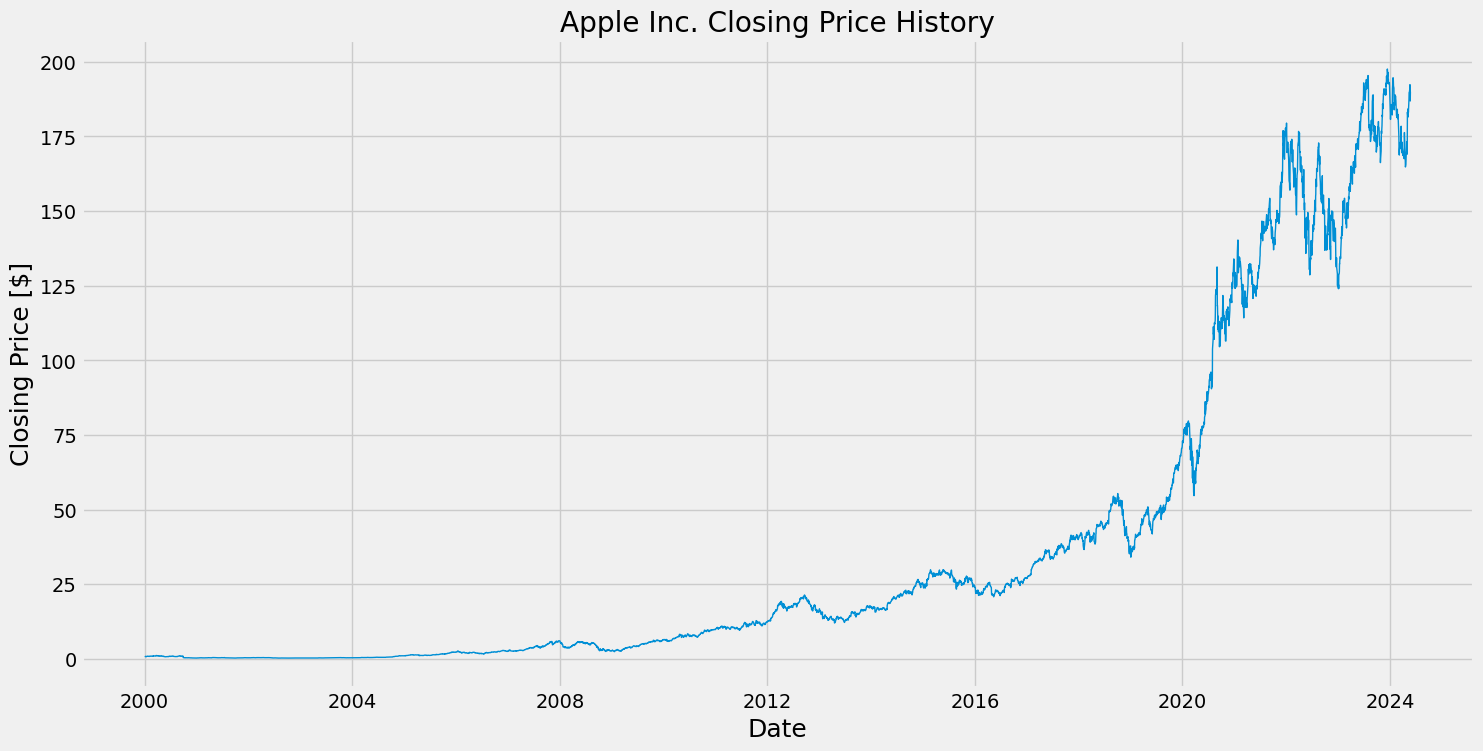

In [13]:
# visualize the closing price history
plt.figure(figsize=(16, 8))
plt.title("Apple Inc. Closing Price History")
plt.plot(df["Close"], lw=1)  # lw = line width
plt.xlabel("Date", fontsize=18)
plt.ylabel("Closing Price [$]", fontsize=18)
plt.show()

# Preprocess Data

In [14]:
warnings.filterwarnings('ignore', category=UserWarning)

## Find Local Extrema

In [15]:
extrema_constant = 4
df['Buy'] = df.iloc[argrelextrema(df["Close"].values, np.less_equal,
                    order=extrema_constant)[0]]["Close"]
df['Sell'] = df.iloc[argrelextrema(df["Close"].values, np.greater_equal,
                    order=extrema_constant)[0]]["Close"]

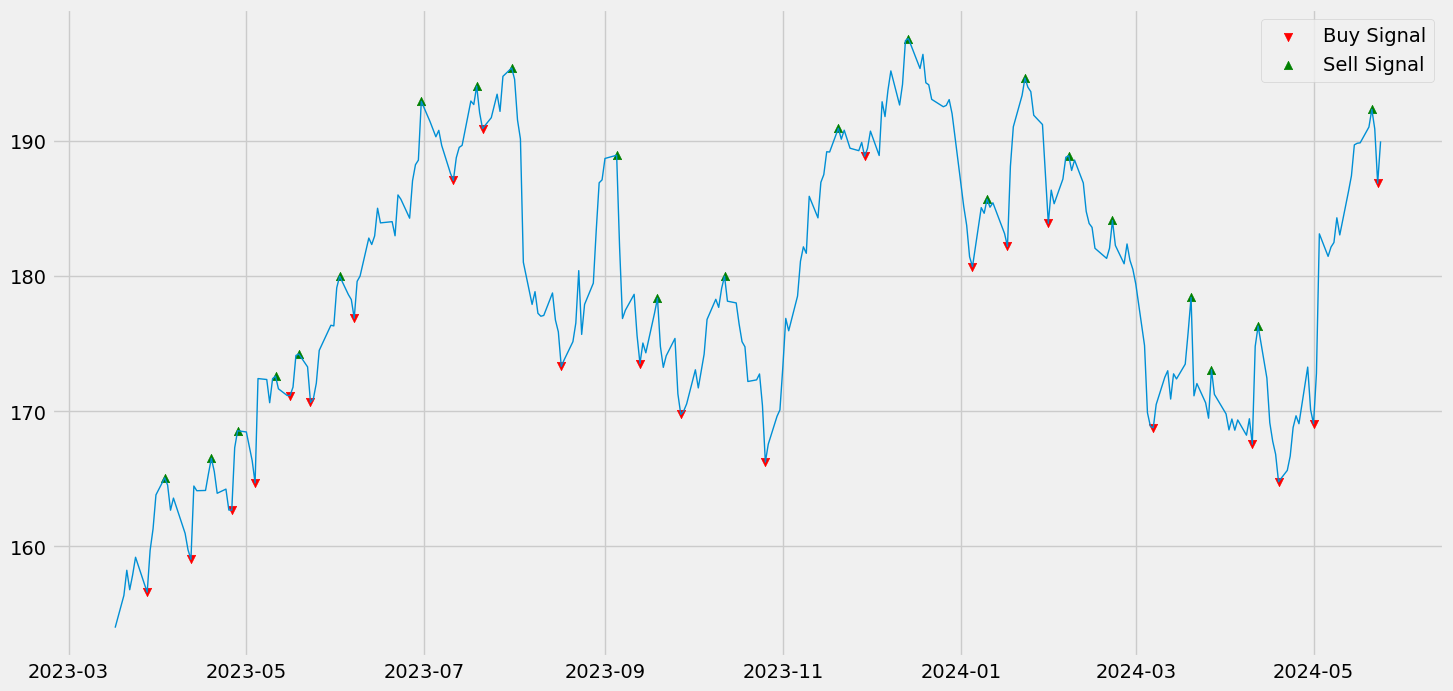

In [16]:
# Plot data
plt.figure(figsize=(16, 8))
plt.plot(df.index[-300:], df["Close"][df.index[-300:]], lw=1)
plt.scatter(df.index[-300:], df['Buy'][df.index[-300:]], c='r', marker="v", label="Buy Signal")
plt.scatter(df.index[-300:], df['Sell'][df.index[-300:]], c='g', marker="^", label="Sell Signal")
plt.legend()
plt.show()

## Delete all Buy_Sell_Signals that follow one of its own --> make signals alternating

In [17]:
# Create Column with Buy and Sell Signals
df["Buy_and_Sell"] = np.nan
for index in df.index:
    if str(df.loc[index, "Buy"]) != "nan":
        df.loc[index, "Buy_and_Sell"] = df.loc[index, "Buy"]
    if str(df.loc[index, "Sell"]) != "nan":
        df.loc[index, "Buy_and_Sell"] = df.loc[index, "Sell"]

# Delete not wanted signals
# --> leave lowest of repeated buy- and highest of repated sell-signals
flag_buy_last = False
flag_sell_last = False
df_reverse = df.iloc[::-1]  # df with rows in reversed order   

for index in df.index:
    if df.loc[index, "Buy"] == df.loc[index, "Buy_and_Sell"]\
    and str(df.loc[index, "Buy"]) != "nan":
        if flag_buy_last == True:
            # get last buy_signal that is not nan
            for index_last in df_reverse.index[df_reverse.index.get_loc(index) + 1:]:
                # df_reverse returns df with reversed indices -->[start:stop:steps]
                # df.index.get_loc(index) gets number of index
                if str(df.loc[index_last, "Buy"]) != "nan":
                    # delete smaller signal value (current or previous)
                    if df.loc[index, "Buy"] < df.loc[index_last, "Buy"]:
                        df.loc[index_last, "Buy"] = np.nan
                    elif df.loc[index, "Buy"] > df.loc[index_last, "Buy"]:
                        df.loc[index, "Buy"] = np.nan
                    elif df.loc[index, "Buy"] == df.loc[index_last, "Buy"]:
                        df.loc[index_last, "Buy"] = np.nan
                    break
        flag_buy_last = True
        flag_sell_last = False
    elif df.loc[index, "Sell"] == df.loc[index, "Buy_and_Sell"]\
    and str(df.loc[index, "Sell"]) != "nan":
        if flag_sell_last == True:
            # get last sell_signal that is not nan
            for index_last in df_reverse.index[df_reverse.index.get_loc(index) + 1:]:
                if str(df.loc[index_last, "Sell"]) != "nan":
                    # delete smaller signal value (current or previous)
                    if df.loc[index, "Sell"] > df.loc[index_last, "Sell"]:
                        df.loc[index_last, "Sell"] = np.nan
                    elif df.loc[index, "Sell"] < df.loc[index_last, "Sell"]:
                        df.loc[index, "Sell"] = np.nan
                    elif df.loc[index, "Sell"] == df.loc[index_last, "Sell"]:
                        df.loc[index, "Sell"] = np.nan
                    break
        flag_sell_last = True
        flag_buy_last = False


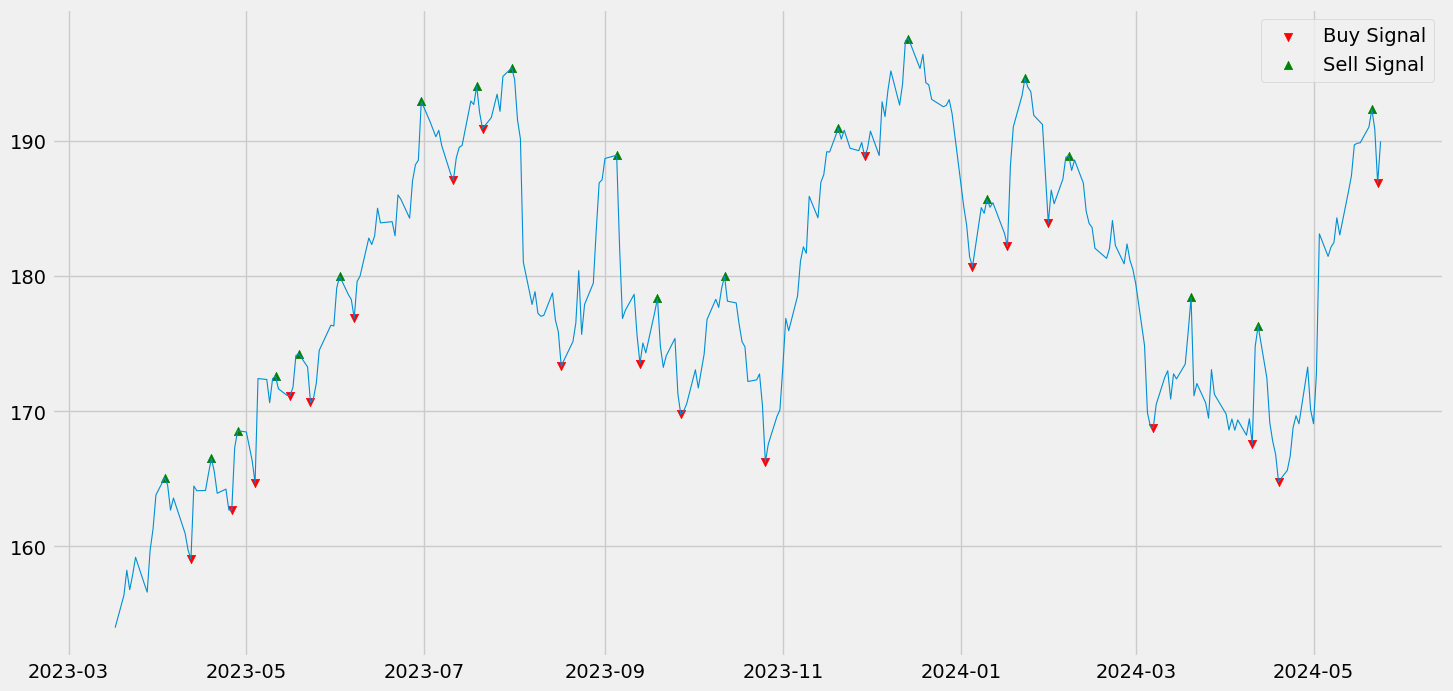

In [18]:
# Plot data
plt.figure(figsize=(16, 8))
plt.plot(df.index[-300:], df["Close"][df.index[-300:]], lw=0.8)
plt.scatter(df.index[-300:], df['Buy'][df.index[-300:]],
            c='r', marker="v", label="Buy Signal")
plt.scatter(df.index[-300:], df['Sell'][df.index[-300:]],
            c='g', marker="^", label="Sell Signal")
plt.legend()
plt.show()

## Calculate Income by this Method

In [19]:
buy_sum = df["Buy"].fillna(0).values.sum()
sell_sum = df["Sell"].fillna(0).values.sum()

# check if last transaction was buy
# if yes, correct it in income sum
for index in df.iloc[::-1].index:
    if str(df.loc[index, "Buy_and_Sell"]) != "nan":
        if df.loc[index, "Buy_and_Sell"] == df.loc[index, "Buy"]:
            last_buy_costs =  float(df.loc[index, "Buy"])
        elif df.loc[index, "Buy_and_Sell"] == df.loc[index, "Sell"]:
            last_buy_costs =  0.0
        break

income = sell_sum - buy_sum + last_buy_costs
print(f"buy_sum: {buy_sum}\nsell_sum: {sell_sum}\nincome: {income}")

buy_sum: 13436.022422268987
sell_sum: 14352.636019483209
income: 1103.4936020970345


## Drop unimportant Columns

In [20]:
df = df[["Close", "Buy", "Sell"]]
df

,Close,Buy,Sell
Date,,,
2000-01-03 00:00:00-05:00,0.844981,NaN,0.844981
2000-01-04 00:00:00-05:00,0.773741,NaN,NaN
2000-01-05 00:00:00-05:00,0.785063,NaN,NaN
2000-01-06 00:00:00-05:00,0.717125,NaN,NaN
2000-01-07 00:00:00-05:00,0.751094,NaN,NaN
...,...,...,...
2024-05-20 00:00:00-04:00,191.039993,NaN,NaN
2024-05-21 00:00:00-04:00,192.350006,NaN,192.350006
2024-05-22 00:00:00-04:00,190.899994,NaN,NaN


## Create floating Recommendation Values from 1 to 0

In [21]:
df.loc[:, "Rec(Buy)"] = np.nan
df.loc[:, "Rec(Sell)"] = np.nan
sell_to_sell_period_list = []
buy_to_buy_period_list = []

scale_max = 1
scale_min = 0

i = 0
for index in df.index:
#1 FILL Rec(Buy) VALUES
    # check for sell_signal
    if str(df.loc[index, "Sell"]) != "nan":
        # clear sell_to_sell_period_list for new period
        sell_to_sell_period_list = []
        # find out the next sell_signal
        for sub_index in df.index[i + 1:]:
            if str(df.loc[sub_index, "Sell"]) != "nan":
                next_sell_signal = df.loc[sub_index, "Sell"]
                break
        # fill sell_to_sell_period_list
        for sub_index in df.index[i + 1:]:
            sell_to_sell_period_list.append(next_sell_signal - df.loc[sub_index, "Close"])
            # scale the filled sell_to_sell_period_list min = scale_min & max = scale_max
            # if next sell_signal is reached
            if str(df.loc[sub_index, "Sell"]) != "nan":
                # transform sell_to_sell_period_list to sell_to_sell_period_np for scaling
                # and reshape it to 2 diemensions for scaling
                # reshape(-1, 1) if 1 feature; reshape(1, -1) if 1 sample
                sell_to_sell_period_np = np.array(sell_to_sell_period_list)\
                                            .reshape(-1, 1)
                print(sell_to_sell_period_np)
                scaler = MinMaxScaler(feature_range=(scale_min, scale_max))
                scaled_sell_to_sell_period_np = scaler.fit_transform(
                                                    sell_to_sell_period_np)
                break
        # set Rec(Buy) values to respective once out of scaled_sell_to_sell_period_list
        j = 0
        for sub_index in df.index[i + 1:]:
            if j == scaled_sell_to_sell_period_np.shape[0]:
                break
            print(scaled_sell_to_sell_period_np[j])
            df.loc[sub_index, "Rec(Buy)"] = scaled_sell_to_sell_period_np[j]
            j += 1
    
#2 FILL Rec(Sell) VALUES
    if str(df.loc[index, "Buy"]) != "nan":
        # clear buy_to_buy_period_list for new period
        buy_to_buy_period_list = []
        # find out the next buy_signal
        for sub_index in df.index[i + 1:]:
            if str(df.loc[sub_index, "Buy"]) != "nan":
                next_buy_signal = df.loc[sub_index, "Buy"]
                break
        # fill buy_to_buy_period_list
        for sub_index in df.index[i + 1:]:
            buy_to_buy_period_list.append(df.loc[sub_index, "Close"] - next_buy_signal)
            # scale the filled buy_to_buy_period_list min = scale_min & max = scale_max
            # if next buy_signal is reached
            if str(df.loc[sub_index, "Buy"]) != "nan":
                # transform buy_to_buy_period_list to buy_to_buy_period_np for scaling
                # and reshape it to 2 diemensions for scaling
                # reshape(-1, 1) if 1 feature; reshape(1, -1) if 1 sample
                buy_to_buy_period_np = np.array(buy_to_buy_period_list)\
                                            .reshape(-1, 1)
                print(buy_to_buy_period_np)
                scaler = MinMaxScaler(feature_range=(scale_min, scale_max))
                scaled_buy_to_buy_period_np = scaler.fit_transform(
                                                    buy_to_buy_period_np)
                break
        # set Rec(Sell) values to respective ones out of scaled_buy_to_buy_period_list
        j = 0
        for sub_index in df.index[i + 1:]:
            if j == scaled_buy_to_buy_period_np.shape[0]:
                break
            print(scaled_buy_to_buy_period_np[j])
            df.loc[sub_index, "Rec(Sell)"] = scaled_buy_to_buy_period_np[j]
            j += 1
    
    i += 1

[[0.08303547]
 [0.07171321]
 [0.13965124]
 [0.10568196]
 [0.11889231]
 [0.15663546]
 [0.19862485]
 [0.12644112]
 [0.09860516]
 [0.07218474]
 [0.0523693 ]
 [0.        ]]
[0.41805177]
[0.36104853]
[0.70309047]
[0.53206815]
[0.59857723]
[0.78859953]
[1.]
[0.63658259]
[0.49643917]
[0.36342251]
[0.26365934]
[0.]
[[-0.01556909]
 [ 0.01226687]
 [ 0.03868729]
 [ 0.05850273]
 [ 0.11087203]
 [ 0.09435922]
 [ 0.05614394]
 [ 0.10143566]
 [ 0.08586687]
 [ 0.08445138]
 [ 0.02123106]
 [ 0.03727168]
 [ 0.0108515 ]
 [ 0.        ]]
[0.]
[0.22014962]
[0.42910391]
[0.58582069]
[1.]
[0.86940316]
[0.56716541]
[0.92536946]
[0.80223869]
[0.79104383]
[0.29104571]
[0.4179081]
[0.2089557]
[0.12313313]
[[0.05803001]
 [0.09624529]
 [0.05095357]
 [0.06652236]
 [0.06793785]
 [0.13115817]
 [0.11511755]
 [0.14153773]
 [0.15238923]
 [0.11841989]
 [0.08303499]
 [0.03727144]
 [0.03113782]
 [0.04812282]
 [0.0415172 ]
 [0.07737404]
 [0.0240615 ]
 [0.        ]]
[0.38080125]
[0.63157541]
[0.33436462]
[0.43652928]
[0.44581793

C:\Users\I568705\AppData\Local\Temp\ipykernel_4888\1575769757.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, "Rec(Buy)"] = np.nan
C:\Users\I568705\AppData\Local\Temp\ipykernel_4888\1575769757.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, "Rec(Sell)"] = np.nan


[[0.08586687]
 [0.10002059]
 [0.07454365]
 [0.07737428]
 [0.11700505]
 [0.15757906]
 [0.1547485 ]
 [0.18399954]
 [0.14814365]
 [0.16607141]
 [0.17550778]
 [0.15946597]
 [0.09058458]
 [0.12738448]
 [0.10379469]
 [0.03019536]
 [0.05095392]
 [0.05095392]
 [0.0802049 ]
 [0.02453369]
 [0.06227714]
 [0.03963077]
 [0.00849277]
 [0.01981598]
 [0.01037967]
 [0.01887232]
 [0.00094348]
 [0.01226687]
 [0.01321042]
 [0.01509845]
 [0.00566214]
 [0.        ]]
[0.46666893]
[0.54359151]
[0.40512958]
[0.42051344]
[0.63589861]
[0.85641011]
[0.84102656]
[1.]
[0.80513055]
[0.9025643]
[0.95384904]
[0.86666505]
[0.49230871]
[0.69230871]
[0.56410301]
[0.1641056]
[0.2769242]
[0.2769242]
[0.43589731]
[0.1333356]
[0.33846356]
[0.21538516]
[0.04615646]
[0.10769582]
[0.0564114]
[0.10256722]
[0.00512763]
[0.06666796]
[0.07179592]
[0.08205701]
[0.03077259]
[0.]
[[0.10473847]
 [0.08681071]
 [0.07737434]
 [0.09341615]
 [0.16229755]
 [0.12549764]
 [0.14908743]
 [0.22268677]
 [0.2019282 ]
 [0.2019282 ]
 [0.17267722]
 [0

In [22]:
df.head(10)  # shows 1st 10 rows

,Close,Buy,Sell,Rec(Buy),Rec(Sell)
Date,,,,,
2000-01-03 00:00:00-05:00,0.844981,NaN,0.844981,NaN,NaN
2000-01-04 00:00:00-05:00,0.773741,NaN,NaN,0.418052,NaN
2000-01-05 00:00:00-05:00,0.785063,NaN,NaN,0.361049,NaN
2000-01-06 00:00:00-05:00,0.717125,NaN,NaN,0.703090,NaN
2000-01-07 00:00:00-05:00,0.751094,NaN,NaN,0.532068,NaN
2000-01-10 00:00:00-05:00,0.737884,NaN,NaN,0.598577,NaN
2000-01-11 00:00:00-05:00,0.700141,NaN,NaN,0.788600,NaN
2000-01-12 00:00:00-05:00,0.658151,0.658151,NaN,1.000000,NaN
2000-01-13 00:00:00-05:00,0.730335,NaN,NaN,0.636583,0.00000


In [23]:
df.tail(8)  # shows last 8 rows

,Close,Buy,Sell,Rec(Buy),Rec(Sell)
Date,,,,,
2024-05-15 00:00:00-04:00,189.720001,NaN,NaN,0.095382,0.901626
2024-05-16 00:00:00-04:00,189.839996,NaN,NaN,0.091030,0.906114
2024-05-17 00:00:00-04:00,189.869995,NaN,NaN,0.089942,0.907236
2024-05-20 00:00:00-04:00,191.039993,NaN,NaN,0.047510,0.950999
2024-05-21 00:00:00-04:00,192.350006,NaN,192.350006,0.000000,1.000000
2024-05-22 00:00:00-04:00,190.899994,NaN,NaN,0.721487,0.945763
2024-05-23 00:00:00-04:00,186.880005,186.880005,NaN,0.841367,0.795397
2024-05-24 00:00:00-04:00,189.979996,NaN,NaN,0.891347,0.000000


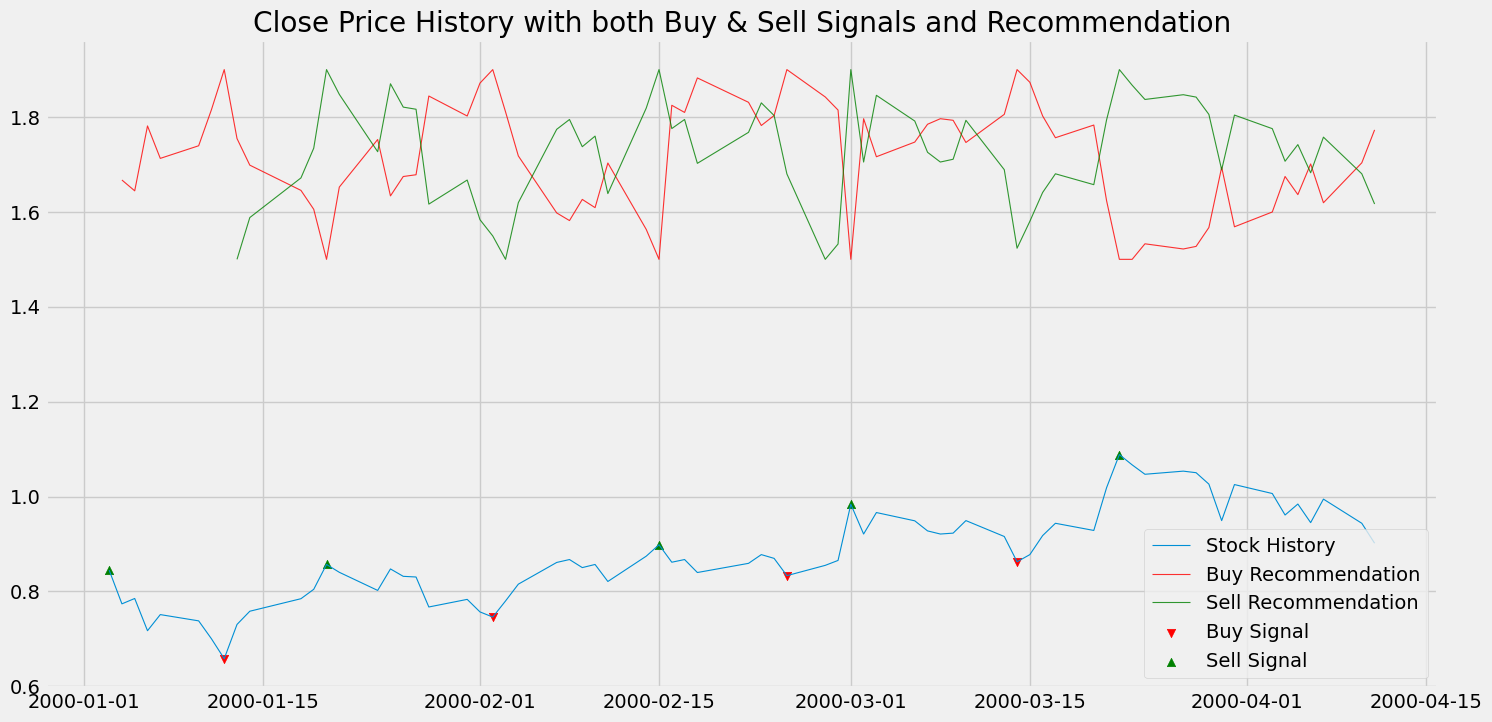

In [24]:
# Plot 1st 100 Days
plt.figure(figsize=(16, 8))
plt.title("Close Price History with both Buy & Sell Signals and Recommendation")
plt.plot(df.index[:70], df["Close"][df.index[:70]], lw=0.8,
         label="Stock History")
plt.plot(df.index[:70], df["Rec(Buy)"][df.index[:70]] * 0.4 + 1.5,
         lw=0.8, alpha = 0.8, label="Buy Recommendation", c='r')
plt.plot(df.index[:70], df["Rec(Sell)"][df.index[:70]] * 0.4 + 1.5,
         lw=0.8, alpha = 0.8, label="Sell Recommendation", c='g')
plt.scatter(df.index[:70], df['Buy'][df.index[:70]],
            c='r', marker="v", label="Buy Signal")
plt.scatter(df.index[:70], df['Sell'][df.index[:70]],
            c='g', marker="^", label="Sell Signal")
plt.legend(loc="lower right")
plt.show()

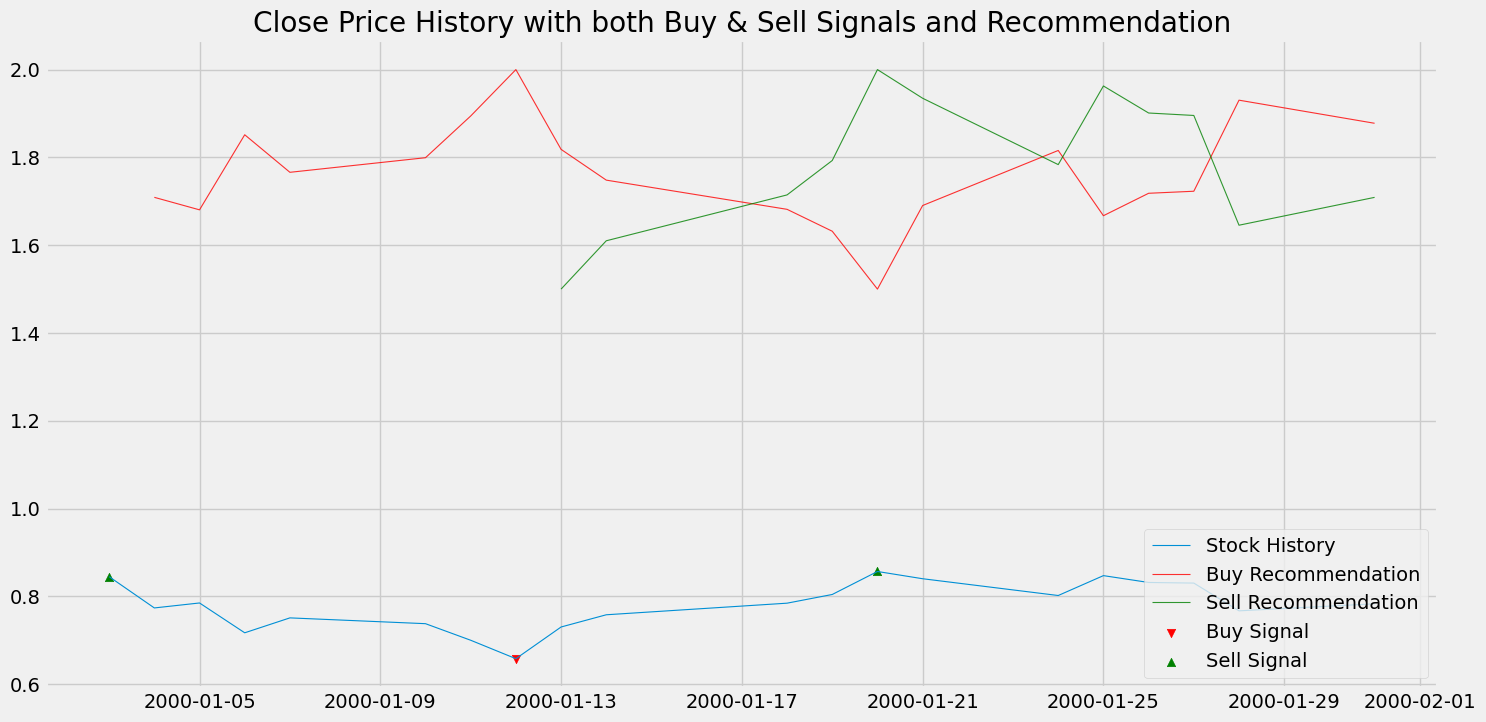

In [25]:
# Plot 1st 20 days
plt.figure(figsize=(16, 8))
plt.title("Close Price History with both Buy & Sell Signals and Recommendation")
plt.plot(df.index[:20], df["Close"][df.index[:20]], lw=0.8,
         label="Stock History")
plt.plot(df.index[:20], df["Rec(Buy)"][df.index[:20]] * 0.5 + 1.5,
         lw=0.8, alpha = 0.8, label="Buy Recommendation", c='r')
plt.plot(df.index[:20], df["Rec(Sell)"][df.index[:20]] * 0.5 + 1.5,
         lw=0.8, alpha = 0.8, label="Sell Recommendation", c='g')
plt.scatter(df.index[:20], df['Buy'][df.index[:20]],
            c='r', marker="v", label="Buy Signal")
plt.scatter(df.index[:20], df['Sell'][df.index[:20]],
            c='g', marker="^", label="Sell Signal")
plt.legend(loc="lower right")
plt.show()

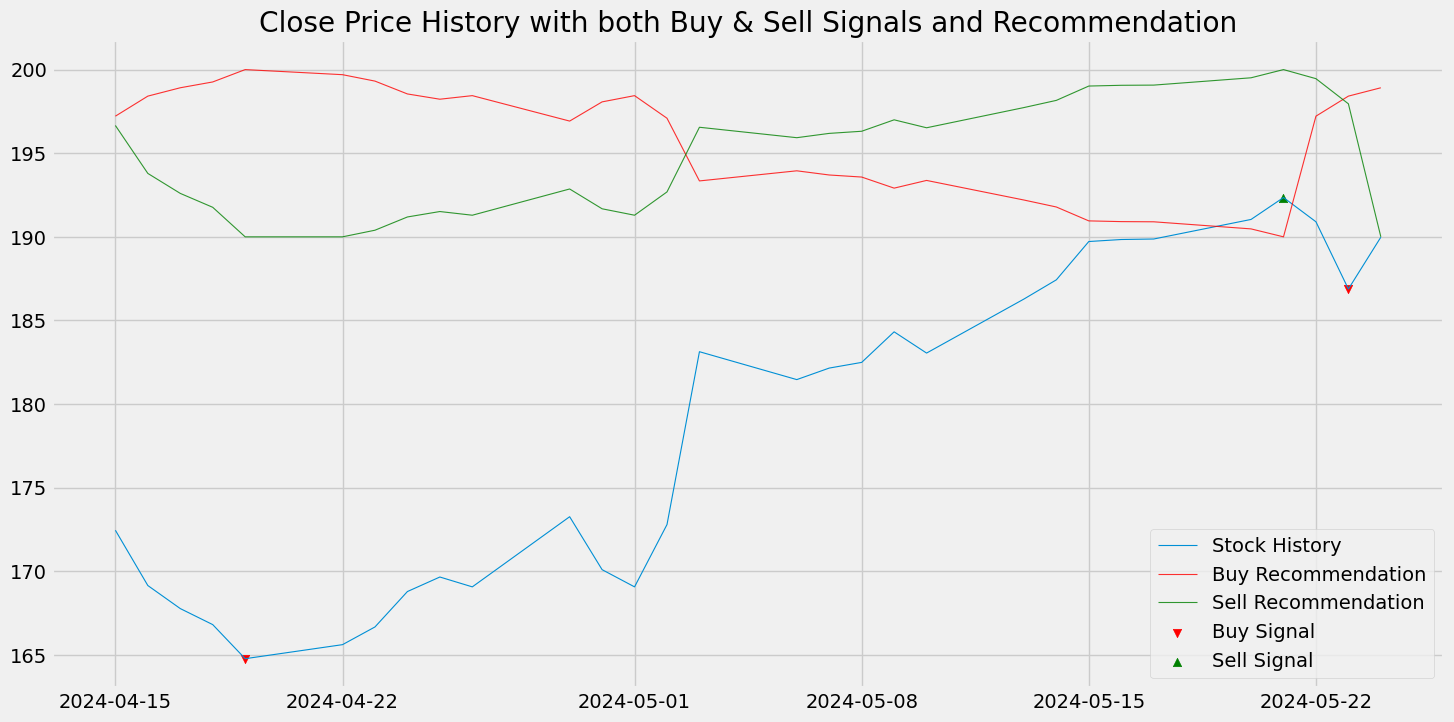

In [26]:
# Plot last 30 days
plt.figure(figsize=(16, 8))
plt.title("Close Price History with both Buy & Sell Signals and Recommendation")
plt.plot(df.index[-30:], df["Close"][df.index[-30:]], lw=0.8,
         label="Stock History")
plt.plot(df.index[-30:], df["Rec(Buy)"][df.index[-30:]] * 10 + 190,
         lw=0.8, alpha = 0.8, label="Buy Recommendation", c='r')
plt.plot(df.index[-30:], df["Rec(Sell)"][df.index[-30:]] * 10 + 190,
         lw=0.8, alpha = 0.8, label="Sell Recommendation", c='g')
plt.scatter(df.index[-30:], df['Buy'][df.index[-30:]],
            c='r', marker="v", label="Buy Signal")
plt.scatter(df.index[-30:], df['Sell'][df.index[-30:]],
            c='g', marker="^", label="Sell Signal")
plt.legend(loc="lower right")
plt.show()

## Check when both R(Sell) and R(Buy) are != "nan" from beginning on

In [27]:
# calculate index_rec_buy_sell_not_nan = first index that isn't nan
index_rec_buy_sell_not_nan = 0
for index in df.index[:100]:
    if str(df["Rec(Sell)"][index]) != "nan" and str(df["Rec(Buy)"][index]) != "nan":
        print(f'Rec(Sell){index_rec_buy_sell_not_nan}: ', df["Rec(Sell)"][index])
        print(f"Rec(Buy){index_rec_buy_sell_not_nan}: ", df["Rec(Buy)"][index])
        print("\nindex_rec_buy_sell_not_nan: ", index_rec_buy_sell_not_nan)
        break
    print(f'Rec(Sell){index_rec_buy_sell_not_nan}: ', df["Rec(Sell)"][index])
    print(f"Rec(Buy){index_rec_buy_sell_not_nan}: ", df["Rec(Buy)"][index])
    index_rec_buy_sell_not_nan += 1
    
df.head(index_rec_buy_sell_not_nan + 2)

Rec(Sell)0:  nan
Rec(Buy)0:  nan
Rec(Sell)1:  nan
Rec(Buy)1:  0.41805176612935174
Rec(Sell)2:  nan
Rec(Buy)2:  0.36104852639501234
Rec(Sell)3:  nan
Rec(Buy)3:  0.7030904712919206
Rec(Sell)4:  nan
Rec(Buy)4:  0.5320681484540142
Rec(Sell)5:  nan
Rec(Buy)5:  0.5985772296730377
Rec(Sell)6:  nan
Rec(Buy)6:  0.7885995321050592
Rec(Sell)7:  nan
Rec(Buy)7:  1.0
Rec(Sell)8:  0.0
Rec(Buy)8:  0.6365825904190768

index_rec_buy_sell_not_nan:  8


,Close,Buy,Sell,Rec(Buy),Rec(Sell)
Date,,,,,
2000-01-03 00:00:00-05:00,0.844981,NaN,0.844981,NaN,NaN
2000-01-04 00:00:00-05:00,0.773741,NaN,NaN,0.418052,NaN
2000-01-05 00:00:00-05:00,0.785063,NaN,NaN,0.361049,NaN
2000-01-06 00:00:00-05:00,0.717125,NaN,NaN,0.703090,NaN
2000-01-07 00:00:00-05:00,0.751094,NaN,NaN,0.532068,NaN
2000-01-10 00:00:00-05:00,0.737884,NaN,NaN,0.598577,NaN
2000-01-11 00:00:00-05:00,0.700141,NaN,NaN,0.788600,NaN
2000-01-12 00:00:00-05:00,0.658151,0.658151,NaN,1.000000,NaN
2000-01-13 00:00:00-05:00,0.730335,NaN,NaN,0.636583,0.00000


## Identify the Buy or Sell Signal before the last one

In [28]:
# identify the Buy or Sell Signal before the last one (important for end of dataset)
i = -1
last_buy_signal_from_end = None
last_sell_signal_from_end = None
for index in reversed(df.index):  # reversed() creates reversed list object of input
    if pd.isna(df['Buy'][index]) == False and last_buy_signal_from_end == None:
        # pd.isna() checks if given value is np.nan and returns True if it is
        last_buy_signal_from_end = i
    if pd.isna(df['Sell'][index]) == False and last_sell_signal_from_end == None:
        last_sell_signal_from_end = i
    if last_buy_signal_from_end != None and last_sell_signal_from_end != None:
        break
    i -=1
    
if last_buy_signal_from_end < last_sell_signal_from_end:
    buy_or_sell_signal_before_the_last_one = last_buy_signal_from_end
elif last_sell_signal_from_end < last_buy_signal_from_end:
    buy_or_sell_signal_before_the_last_one = last_sell_signal_from_end
else:
    print(
        f"ERROR while identifing buy_or_sell_signal_before_the_last_one"
    )

print(
    f"buy_or_sell_signal_before_the_last_one: {buy_or_sell_signal_before_the_last_one}\
    \nlast_buy_signal_from_end: {last_buy_signal_from_end}\
    \nlast_sell_signal_from_end: {last_sell_signal_from_end}"
    )


buy_or_sell_signal_before_the_last_one: -4    
last_buy_signal_from_end: -2    
last_sell_signal_from_end: -4


=> Datasets using these buy or or sell signals should only reach from index_rec_buy_sell_not_nan to buy_or_sell_signal_before_the_last_one + 1

## Create categorical columns for buy, sell, and hold recommendations using 0 and 1

In [29]:
# Categorical Sell should be when Rec(Buy) is < .33, Sell when its > .66, Hold in between
df.loc[:, "Rec(Sell)_cat"] = df.loc[:, 'Rec(Buy)'].apply(lambda x: 1 if x < 0.33 else 0)
df.loc[:, 'Rec(Hold)_cat'] = df.loc[:, 'Rec(Buy)'].apply(lambda x: 1 if 0.33 <= x <= 0.66 else 0)
df.loc[:, "Rec(Buy)_cat"] = df.loc[:, 'Rec(Buy)'].apply(lambda x: 1 if x > 0.66 else 0)
df

C:\Users\I568705\AppData\Local\Temp\ipykernel_4888\1028370835.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, "Rec(Sell)_cat"] = df.loc[:, 'Rec(Buy)'].apply(lambda x: 1 if x < 0.33 else 0)
C:\Users\I568705\AppData\Local\Temp\ipykernel_4888\1028370835.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'Rec(Hold)_cat'] = df.loc[:, 'Rec(Buy)'].apply(lambda x: 1 if 0.33 <= x <= 0.66 else 0)
C:\Users\I568705\AppData\Local\Temp\ipykernel_4888\1028370835.py:4: SettingWithCopyWarning: 
A va

,Close,Buy,Sell,Rec(Buy),Rec(Sell),Rec(Sell)_cat,Rec(Hold)_cat,Rec(Buy)_cat
Date,,,,,,,,
2000-01-03 00:00:00-05:00,0.844981,NaN,0.844981,NaN,NaN,0,0,0
2000-01-04 00:00:00-05:00,0.773741,NaN,NaN,0.418052,NaN,0,1,0
2000-01-05 00:00:00-05:00,0.785063,NaN,NaN,0.361049,NaN,0,1,0
2000-01-06 00:00:00-05:00,0.717125,NaN,NaN,0.703090,NaN,0,0,1
2000-01-07 00:00:00-05:00,0.751094,NaN,NaN,0.532068,NaN,0,1,0
...,...,...,...,...,...,...,...,...
2024-05-20 00:00:00-04:00,191.039993,NaN,NaN,0.047510,0.950999,1,0,0
2024-05-21 00:00:00-04:00,192.350006,NaN,192.350006,0.000000,1.000000,1,0,0
2024-05-22 00:00:00-04:00,190.899994,NaN,NaN,0.721487,0.945763,0,0,1


In [70]:
df.loc[:, "Rec(Buy)_bin"] = df.loc[:, 'Rec(Buy)'].apply(lambda x: 1 if x > 0.5 else 0)
df

C:\Users\I568705\AppData\Local\Temp\ipykernel_4888\433582745.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, "Rec(Buy)_bin"] = df.loc[:, 'Rec(Buy)'].apply(lambda x: 1 if x > 0.5 else 0)


,Close,Buy,Sell,Rec(Buy),Rec(Sell),Rec(Sell)_cat,Rec(Hold)_cat,Rec(Buy)_cat,Rec(Buy)_bin
Date,,,,,,,,,
2000-01-03 00:00:00-05:00,0.844981,NaN,0.844981,NaN,NaN,0,0,0,0
2000-01-04 00:00:00-05:00,0.773741,NaN,NaN,0.418052,NaN,0,1,0,0
2000-01-05 00:00:00-05:00,0.785063,NaN,NaN,0.361049,NaN,0,1,0,0
2000-01-06 00:00:00-05:00,0.717125,NaN,NaN,0.703090,NaN,0,0,1,1
2000-01-07 00:00:00-05:00,0.751094,NaN,NaN,0.532068,NaN,0,1,0,1
...,...,...,...,...,...,...,...,...,...
2024-05-20 00:00:00-04:00,191.039993,NaN,NaN,0.047510,0.950999,1,0,0,0
2024-05-21 00:00:00-04:00,192.350006,NaN,192.350006,0.000000,1.000000,1,0,0,0
2024-05-22 00:00:00-04:00,190.899994,NaN,NaN,0.721487,0.945763,0,0,1,1


## Create dataset out of df["Close"]

In [30]:
# convert df to np-array
dataset = df.loc[
    df.index[index_rec_buy_sell_not_nan]:df.index[buy_or_sell_signal_before_the_last_one + 1],
    "Close"
]

In [31]:
df.tail(25), dataset[-5:]

(                                Close         Buy        Sell  Rec(Buy)  \
 Date                                                                      
 2024-04-22 00:00:00-04:00  165.615356         NaN         NaN  0.969578   
 2024-04-23 00:00:00-04:00  166.673920         NaN         NaN  0.931187   
 2024-04-24 00:00:00-04:00  168.791061         NaN         NaN  0.854405   
 2024-04-25 00:00:00-04:00  169.659882         NaN         NaN  0.822896   
 2024-04-26 00:00:00-04:00  169.070679         NaN         NaN  0.844264   
 2024-04-29 00:00:00-04:00  173.264984         NaN         NaN  0.692151   
 2024-04-30 00:00:00-04:00  170.099289         NaN         NaN  0.806960   
 2024-05-01 00:00:00-04:00  169.070679         NaN         NaN  0.844264   
 2024-05-02 00:00:00-04:00  172.795624         NaN         NaN  0.709173   
 2024-05-03 00:00:00-04:00  183.131607         NaN         NaN  0.334321   
 2024-05-06 00:00:00-04:00  181.463882         NaN         NaN  0.394804   
 2024-05-07 

## Scale dataset

In [ ]:
# make data set a numpy array and reshape it for scaling
dataset = np.array(dataset)
dataset = dataset.reshape(dataset.shape[0], 1)
dataset.shape

(6128, 1)

In [33]:
# Scale data from scale_min to scale_max
scaler = MinMaxScaler(feature_range=(scale_min, scale_max))
scaled_data = scaler.fit_transform(dataset)
scaled_data
scaled_data.shape

(6128, 1)

# Fuction that evaluates the Model

Method that is used to handle cross-validation behavior (assigning x and y to test and training data) below:\
**"Stratified Shuffle & Split"**\
see details of sklearn.model_selection.ShuffleSplit at\
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html \

vizualisation of cross-validation (CV) behavior:\
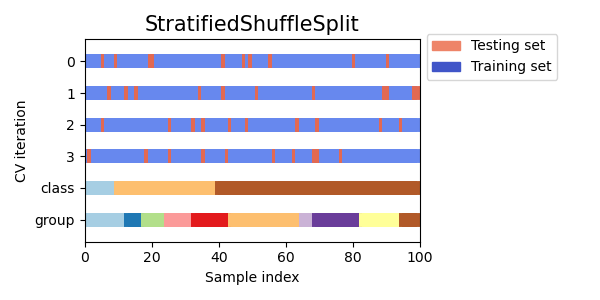

In [82]:
# create evaluate_model function
# (with bootstraping
#   = method to split x and y in test & train data see exmaple in picture above)

# the variable parameters in the evaluate_model function are these that will get optimized
# --> all others has to be fixed
def evaluate_model(
    neuron_percent_x, neuron_shrink, dropout_rate, # has to be float between 0 and 1
#     learning_rate,
    history_days,
    neuron_count_min, layer_no_max,  # has to be integer
    first_by_all_layers_ratio,  # first layer no will get rounded down
    epochs=20, batch_size=128,
    activation_function_out="sigmoid", activation_function_dense="relu",
    loss_function="binary_crossentropy",
        # (has to be "binary_crossentropy" or "mean_squared_error")
    first_layer_type="LSTM",  # at current state only "Dense" or "LSTM"
    second_layer_type="Dense",  # can't be LSTM (at current state only "Dense")
    # train_size=0.5,
    test_size=0.25,  # has to be float between 0 and 1
    optimizer="adam",  # only works with adam at current state
    metrics=["binary_accuracy"],
    check_nan_or_inf=False,
    print_model_summary=False,
    model_verbose = 0,
    df=df,
    scaled_data=scaled_data,
    target_data="buy_sell"
):
    global x_train
    # Bootstrap
    SPLITS = 2
    boot = StratifiedShuffleSplit(
        n_splits=SPLITS,
        test_size=test_size,
        # train_size=train_size,
        random_state=1
    )
        # test_size = 20% of x and y

    # Track progress
    mean_benchmark = []
    epochs_needed = []
    current_SPLIT = 0
    
    # Create x and y; x = training and testing data (independent variable),
    # y = traget (dependent) variable
    x = []
    y = []

    # x = data of history_days days (interating forward)
    # y = last value of history_days days
    history_days = int(round(history_days, 0))

    for i in range(history_days, scaled_data.shape[0]):
        x.append(scaled_data[i - history_days:i, 0])  # index_rec_buy_sell_not_nan already was added by creating the dataset

        if target_data == "buy_sell_hold":
            y.append(
                # index_rec_buy_sell_not_nan has to be added because of index of df is used
                [
                    df["Rec(Buy)_cat"][df.index[i + index_rec_buy_sell_not_nan]],
                    df["Rec(Hold)_cat"][df.index[i + index_rec_buy_sell_not_nan]],
                    df["Rec(Sell)_cat"][df.index[i + index_rec_buy_sell_not_nan]]
                    # df["Rec(Buy)_bin"][df.index[i + index_rec_buy_sell_not_nan]]
                ]
            )
        elif target_data == "buy_sell":
            y.append(
                # index_rec_buy_sell_not_nan has to be added because of index of df is used
                [
                    df["Rec(Buy)_bin"][df.index[i + index_rec_buy_sell_not_nan]]
                ]
            )
        else:
            raise ValueError("set parameter target_data to 'buy_sell_hold' or 'buy_sell'")
        
    x = np.array(x)
    y = np.array(y)

    # Loop through samples
    for train, test in boot.split(x,y):
        start_time = time.time()
        current_SPLIT += 1

        # Split train and test
        x_train = x[train]
        x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
        y_train = y[train]
        x_test = x[test]
        x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
        y_test = y[test]
        
        # check if there are nan or infinite values
        if check_nan_or_inf:
            # numpy_train.isnan(ar)     # True wherever nan
            # numpy_train.isinf(ar)     # True wherever pos-inf or neg-inf

            ar_nan_x_train = np.where(np.isnan(x_train))
            ar_nan_x_test = np.where(np.isnan(x_test))

            ar_inf_x_train = np.where(np.isinf(x_train))
            ar_inf_x_test = np.where(np.isinf(x_test))

            ar_nan_y_train = np.where(np.isnan(y_train))
            ar_nan_y_test = np.where(np.isnan(y_test))

            ar_inf_y_train = np.where(np.isinf(y_train))
            ar_inf_y_test = np.where(np.isinf(y_test))

            ar_nan_inf_string_list = [
                'ar_nan_x_train', 'ar_nan_x_test', 'ar_inf_x_train', 'ar_inf_x_test',
                'ar_nan_y_train', 'ar_nan_y_test', 'ar_inf_y_train', 'ar_inf_y_test'
            ]
            
            i = 0
            for j, k, l in [ar_nan_x_train, ar_nan_x_test, ar_inf_x_train, ar_inf_x_test]:
                if (j.size and k.size and l.size) == 0:
                    # np_array.size == 0 checks if array is empty
                    print(
                        f"no nan or infinite value in {ar_nan_inf_string_list[i]}"
                        f" of SPLIT No {current_SPLIT}"
                    )
                else:
                    print(
                        f"{ar_nan_inf_string_list[i]}:\
                        \n{j, k, l}"
                    )
                i += 1

            for j, k in [ar_nan_y_train, ar_nan_y_test, ar_inf_y_train, ar_inf_y_test]:
                if (j.size and k.size) == 0:
                    print(f"no nan or infinite value in {ar_nan_inf_string_list[i]}"
                        f" of SPLIT No {current_SPLIT}"
                    )
                else:
                    print(
                        f"{ar_nan_inf_string_list[i]}:\
                        \n{j, k}"
                    )
                i += 1


        # create model        
        model = create_model(
            x_train=x_train, y_train=y_train,
            first_layer_type=first_layer_type, second_layer_type=second_layer_type,
            neuron_percent_x=neuron_percent_x, neuron_shrink=neuron_shrink,
            dropout_rate=dropout_rate,
            neuron_count_min=int(round(neuron_count_min, 0)),
            layer_no_max=int(round(layer_no_max)),
            activation_function_out=activation_function_out,
            activation_function_dense=activation_function_dense,
            first_by_all_layers_ratio=first_by_all_layers_ratio
        )

        if print_model_summary:
            model.summary()

        # rescale the x_train and y_train from -1 to 1 if LSTM is first layer
        # ... (LSTM uses tanh as activation function --> scaling between -1 to 1 is more reasonable)
        if layer_type_list[0] == "LSTM":
            # Reshape to 2D for scaling
            x_train_2d = x_train.reshape(-1, 1)
            y_train_2d = y_train.reshape(-1, 1)

            # Scale data to range [-1, 1]
            scaler = MinMaxScaler(feature_range=(-1, 1))
            x_train_2d_scaled = scaler.fit_transform(x_train_2d)
            y_train_2d_scaled = scaler.fit_transform(y_train_2d)

            # Reshape back to 3D
            x_train = x_train_2d_scaled.reshape(x_train.shape)
            y_train = y_train_2d_scaled.reshape(y_train.shape)
        
        # if fist layer is Dense and not LSTM input_dim of x has to be 2 not 3
        if layer_type_list[0] == 'Dense':
            x_train = x_train.reshape(x_train.shape[0], x_train.shape[1])
            x_test = x_test.reshape(x_test.shape[0], x_test.shape[1])
        
        # compile model
        model.compile(
            loss=loss_function,
#             optimizer=Adam(learning_rate=learning_rate),
            optimizer=optimizer,
            metrics=metrics
        )
        monitor = EarlyStopping(
            monitor='val_loss', min_delta=1e-3, patience=100,
            verbose=model_verbose,
            mode='auto',
            restore_best_weights=True
        )

        # Train on the bootstrap sample
        # print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
        model.fit(
            x_train, y_train, validation_data=(x_test, y_test),
            callbacks=[monitor],
            verbose=model_verbose,
            epochs=int(round(epochs, 0)), batch_size=int(round(batch_size, 0))
        )
        epochs_for_tracking = monitor.stopped_epoch
        epochs_needed.append(epochs_for_tracking)

        # Predict on the out of boot (validation)
        y_pred = model.predict(x_test)

        # Measure this bootstrap's loss (score)
        if loss_function == "mean_squared_error":
            loss_fn_obj = MeanSquaredError()
        elif loss_function == "binary_crossentropy":
            loss_fn_obj = BinaryCrossentropy()  # y_test should be binary (0, 1) and y_pred float
        elif loss_function == "categorical_crossentropy":
            loss_fn_obj = CategoricalCrossentropy()  # y_test should be binary (0, 1) and y_pred float
        else:
            raise ValueError("set parameter loss_function to 'mean_squared_error', 'binary_crossentropy', or categorical_crossentropy")
        
        score = loss_fn_obj(y_test, y_pred).numpy()
        mean_benchmark.append(score)
        m1 = statistics.mean(mean_benchmark)
        m2 = statistics.mean(epochs_needed)
        mdev = statistics.pstdev(mean_benchmark)

        # Record this iteration
        time_took = time.time() - start_time
        
    tensorflow.keras.backend.clear_session()
    return(-m1)

## Test the function for different problems

Different hyperparameters of different problems

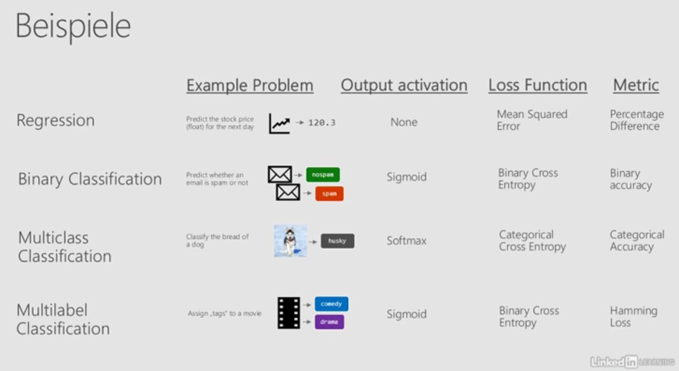

In [75]:
# model eval set for binary classification problems
loss = evaluate_model(
    neuron_percent_x=0.9, neuron_shrink=0.6, dropout_rate=0.2,
    neuron_count_min=10, layer_no_max=8,
    # learning_rate=0.01,
    history_days=30,
    first_by_all_layers_ratio=0.5,
    loss_function="binary_crossentropy",
    activation_function_out="sigmoid",
    metrics=["binary_accuracy"],
    print_model_summary=True,
    check_nan_or_inf=False,
    model_verbose=1,
    target_data="buy_sell"
)

resulting_layer_no: 3


Model: "Dense_or_Dense_LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ LSTM_Layer_1 (LSTM)             │ (None, 30, 27)         │         3,132 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_Layer_1 (Dropout)       │ (None, 30, 27)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_Layer_2 (LSTM)             │ (None, 16)             │         2,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_Layer_2 (Dropout)       │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_Layer_3 (Dense)           │ (None, 10)             │           170 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_Layer_3 (Dropout)       │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_Layer (Dense)            │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,129 (23.94 KB)

 Trainable params: 6,129 (23.94 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - binary_accuracy: 0.0440 - loss: 0.6163 - val_binary_accuracy: 0.4361 - val_loss: 0.7721
Epoch 2/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - binary_accuracy: 0.0041 - loss: 0.4346 - val_binary_accuracy: 0.4361 - val_loss: 1.1467
Epoch 3/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - binary_accuracy: 0.0000e+00 - loss: 0.4363 - val_binary_accuracy: 0.4361 - val_loss: 1.2334
Epoch 4/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - binary_accuracy: 0.0000e+00 - loss: 0.4476 - val_binary_accuracy: 0.4361 - val_loss: 1.2538
Epoch 5/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - binary_accuracy: 0.0000e+00 - loss: 0.3868 - val_binary_accuracy: 0.4361 - val_loss: 1.2263
Epoch 6/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - binary_accuracy: 1.0810e-04 - loss: 0.4461 - val_binary_accuracy: 0.4361 - val_loss: 1.1804
Epoch 7/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - binary_accuracy: 0.0000e+00 - loss: 0.4001 - val_binary_accuracy: 0.4361 - val_loss: 

Model: "Dense_or_Dense_LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ LSTM_Layer_1 (LSTM)             │ (None, 30, 27)         │         3,132 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_Layer_1 (Dropout)       │ (None, 30, 27)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_Layer_2 (LSTM)             │ (None, 16)             │         2,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_Layer_2 (Dropout)       │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_Layer_3 (Dense)           │ (None, 10)             │           170 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_Layer_3 (Dropout)       │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_Layer (Dense)            │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,129 (23.94 KB)

 Trainable params: 6,129 (23.94 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - binary_accuracy: 0.0897 - loss: 0.6290 - val_binary_accuracy: 0.4361 - val_loss: 0.7494
Epoch 2/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - binary_accuracy: 0.0113 - loss: 0.4628 - val_binary_accuracy: 0.4361 - val_loss: 1.0105
Epoch 3/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - binary_accuracy: 0.0059 - loss: 0.4197 - val_binary_accuracy: 0.4361 - val_loss: 1.1179
Epoch 4/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - binary_accuracy: 0.0013 - loss: 0.4272 - val_binary_accuracy: 0.4361 - val_loss: 1.1168
Epoch 5/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - binary_accuracy: 4.5619e-04 - loss: 0.3900 - val_binary_accuracy: 0.4361 - val_loss: 1.1298
Epoch 6/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - binary_accuracy: 2.9007e-04 - loss: 0.3964 - val_binary_accuracy: 0.4361 - val_loss: 1.1224
Epoch 7/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - binary_accuracy: 0.0000e+00 - loss: 0.4443 - val_binary_accuracy: 0.4361 - val_loss: 1.1840
E

In [66]:
# model eval set for multi-classification problems
loss = evaluate_model(
    neuron_percent_x=0.9, neuron_shrink=0.6, dropout_rate=0.2,
    neuron_count_min=10, layer_no_max=8,
    # learning_rate=0.01,
    history_days=30,
    first_by_all_layers_ratio=0.5,
    loss_function="categorical_crossentropy",
    activation_function_out="softmax",
    metrics=["categorical_accuracy"],
    print_model_summary=True,
    check_nan_or_inf=False,
    model_verbose=1,
    target_data="buy_sell_hold"
)

resulting_layer_no: 3


Model: "Dense_or_Dense_LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ LSTM_Layer_1 (LSTM)             │ (None, 30, 27)         │         3,132 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_Layer_1 (Dropout)       │ (None, 30, 27)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_Layer_2 (LSTM)             │ (None, 16)             │         2,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_Layer_2 (Dropout)       │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_Layer_3 (Dense)           │ (None, 10)             │           170 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_Layer_3 (Dropout)       │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_Layer (Dense)            │ (None, 3)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,151 (24.03 KB)

 Trainable params: 6,151 (24.03 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - categorical_accuracy: 0.3229 - loss: -1.0925 - val_categorical_accuracy: 0.3259 - val_loss: 1.1453
Epoch 2/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - categorical_accuracy: 0.3175 - loss: -1.1342 - val_categorical_accuracy: 0.3023 - val_loss: 1.1602
Epoch 3/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - categorical_accuracy: 0.3331 - loss: -1.2841 - val_categorical_accuracy: 0.3023 - val_loss: 1.1124
Epoch 4/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - categorical_accuracy: 0.3539 - loss: -1.5635 - val_categorical_accuracy: 0.4085 - val_loss: 1.1894
Epoch 5/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - categorical_accuracy: 0.3885 - loss: -2.2034 - val_categorical_accuracy: 0.4085 - val_loss: 1.2791
Epoch 6/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - categorical_accuracy: 0.3822 - loss: -2.7849 - val_categorical_accuracy: 0.3023 - val_loss: 1.5174
Epoch 7/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - categorical_accuracy: 0.3458 - loss

Model: "Dense_or_Dense_LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ LSTM_Layer_1 (LSTM)             │ (None, 30, 27)         │         3,132 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_Layer_1 (Dropout)       │ (None, 30, 27)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_Layer_2 (LSTM)             │ (None, 16)             │         2,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_Layer_2 (Dropout)       │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_Layer_3 (Dense)           │ (None, 10)             │           170 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_Layer_3 (Dropout)       │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_Layer (Dense)            │ (None, 3)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,151 (24.03 KB)

 Trainable params: 6,151 (24.03 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - categorical_accuracy: 0.3455 - loss: -1.1606 - val_categorical_accuracy: 0.3882 - val_loss: 1.1020
Epoch 2/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - categorical_accuracy: 0.3721 - loss: -1.5412 - val_categorical_accuracy: 0.4085 - val_loss: 1.2239
Epoch 3/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - categorical_accuracy: 0.3661 - loss: -1.9245 - val_categorical_accuracy: 0.4085 - val_loss: 1.2999
Epoch 4/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - categorical_accuracy: 0.3527 - loss: -2.2787 - val_categorical_accuracy: 0.2892 - val_loss: 1.6018
Epoch 5/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - categorical_accuracy: 0.3219 - loss: -2.7782 - val_categorical_accuracy: 0.2892 - val_loss: 2.0157
Epoch 6/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - categorical_accuracy: 0.3163 - loss: -3.4319 - val_categorical_accuracy: 0.2892 - val_loss: 2.4513
Epoch 7/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - categorical_accuracy: 0.3361 - loss

In [61]:
loss

-1.1388047

# Run Optimization

## Compare standard optimizer and mutated optimizer

### Define and run Optimizers

In [83]:
# Try to contract pbounds with SequentialDomainReductionTransformer
# see:
    # https://github.com/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_08_4_bayesian_hyperparameter_opt.ipynb
    # https://github.com/fmfn/BayesianOptimization
    # and https://github.com/fmfn/BayesianOptimization/blob/master/examples/domain_reduction.ipynb

warnings.filterwarnings('ignore', category=UserWarning)

n_iter = 15
# How many steps of bayesian optimization you want to perform.
# The more steps the more likely to find a good maximum you are.

init_points = 3
# How many steps of random exploration you want to perform.
# Random exploration can help by diversifying the exploration space.

# Bounded region of hyperparameter space
pbounds_for_contract = {
    'dropout_rate': (0, 0.499),
    # 'epochs': (3, 20),
    'first_by_all_layers_ratio': (0.1, 0.9),
    'history_days': (30, 90),
    'layer_no_max': (4, 20),
#     'learning_rate': (0.0001, 0.15),
    'neuron_count_min': (3, 10),
    'neuron_percent_x': (0.1, 0.9),
    'neuron_shrink': (0.1, 0.9),   
#     'batch_size': (32, 128)
}

bounds_transformer = SequentialDomainReductionTransformer()

mutating_optimizer = BayesianOptimization(
    f=evaluate_model,
    pbounds=pbounds_for_contract,
    verbose=2,
    random_state=1,
    bounds_transformer=bounds_transformer
)

mutating_optimizer.maximize(
    init_points=init_points,
    n_iter=n_iter,
)

print(
    50*"=",
    50*"=",
    50*"=",
    sep="\n"
)

standard_optimizer = BayesianOptimization(
    f=evaluate_model,
    pbounds=pbounds_for_contract,
    verbose=2,
    random_state=1,
)


standard_optimizer.maximize(
    init_points=init_points,
    n_iter=n_iter,
)


|   iter    |  target   | dropou... | first_... | histor... | layer_... | neuron... | neuron... | neuron... |
-------------------------------------------------------------------------------------------------------------
resulting_layer_no: 1
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
resulting_layer_no: 1
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
| 1         | -0.6994   | 0.2081    | 0.6763    | 30.01     | 8.837     | 4.027     | 0.1739    | 0.249     |
resulting_layer_no: 4
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
resulting_layer_no: 4
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
| 2         | -0.7045   | 0.1724    | 0.4174    | 62.33     | 10.71     | 7.797     | 0.2636    | 0.8025    |
resulting_layer_no: 5
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
resulting_layer_no: 5
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
| 3         | -0.7232   | 0.01367   | 0.6364    | 55.04     | 12.94     | 3.983     | 0.2585    | 0.7406    |
resulting_layer_no: 4
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
resulting_layer_no:

### Show Results

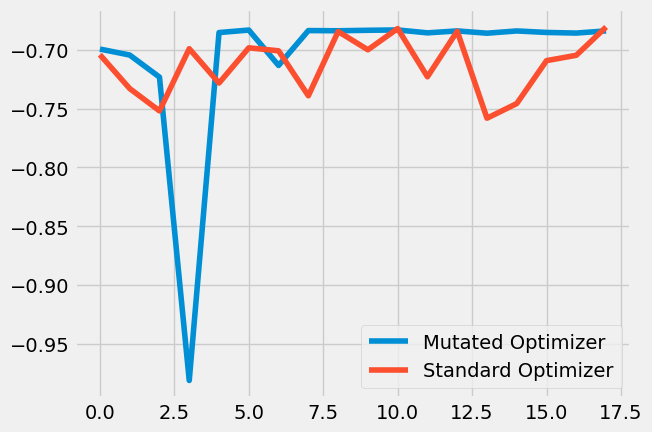

In [84]:
# plot performance comparison
plt.plot(mutating_optimizer.space.target, label='Mutated Optimizer')
plt.plot(standard_optimizer.space.target, label='Standard Optimizer')
plt.legend()

In [41]:
# # probe specific hyperparameters
# mutating_optimizer.probe(
#     params={
#         'dropout_rate': 0.2,
#         'first_by_all_layers_ratio': 0.6,
#         'history_days': 200,
#         'layer_no_max': 15,
#         'neuron_count_min': 6,
#         'neuron_percent_x': 0.7,
#         'neuron_shrink': 0.6
#     },
#     lazy=True,
# )
# mutating_optimizer.maximize(init_points=0, n_iter=0)

## Continue with better optimizer for some further iterations

In [85]:
mutating_optimizer_cont = mutating_optimizer
mutating_optimizer_cont.maximize(
    init_points=0,
    n_iter=20,
)

|   iter    |  target   | dropou... | first_... | histor... | layer_... | neuron... | neuron... | neuron... |
-------------------------------------------------------------------------------------------------------------
resulting_layer_no: 1
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
resulting_layer_no: 1
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step
| 19        | -0.6843   | 0.4628    | 0.1562    | 39.05     | 14.39     | 6.115     | 0.2814    | 0.3869    |
resulting_layer_no: 1
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 821us/step
resulting_layer_no: 1
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
| 20        | -0.6847   | 0.4756    | 0.197     | 40.45     | 12.23     | 5.238     | 0.2617    | 0.3698    |
resulting_layer_no: 1
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
resulting_layer_no: 1
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
| 21        | -0.6839   | 0.4892    | 0.1676    | 40.23     | 12.22     | 5.56      | 0.2446    | 0.3261    |
resulting_layer_no: 1
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step
resulting_layer_n

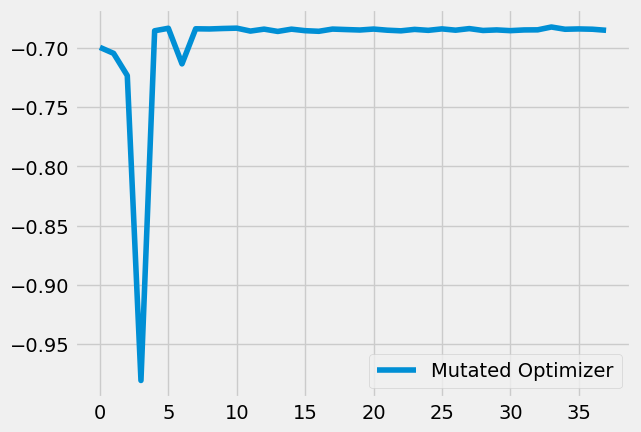

In [86]:
# show further results
plt.plot(mutating_optimizer.space.target, label='Mutated Optimizer')
plt.legend()

### Investigate bounds of mutating optimizer

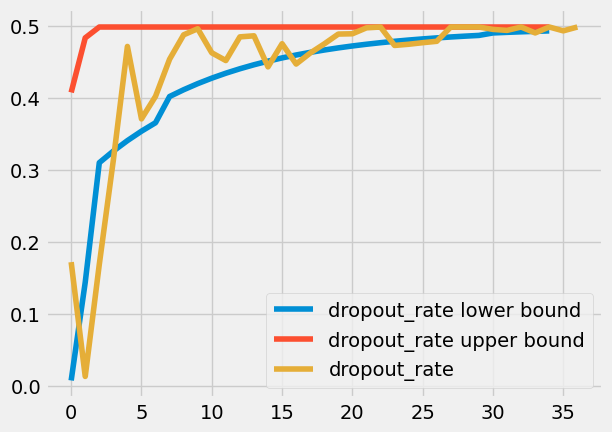

In [87]:
# example dropout_rate-bound shrinking
dropout_rate_min_bound = [b[0][0] for b in bounds_transformer.bounds]
dropout_rate_max_bound = [b[0][1] for b in bounds_transformer.bounds]
dropout_rate = [dropout_rate[0] for dropout_rate in mutating_optimizer_cont.space.params]

plt.plot(dropout_rate_min_bound[1:], label='dropout_rate lower bound')
plt.plot(dropout_rate_max_bound[1:], label='dropout_rate upper bound')
plt.plot(dropout_rate[1:], label='dropout_rate')
plt.legend()

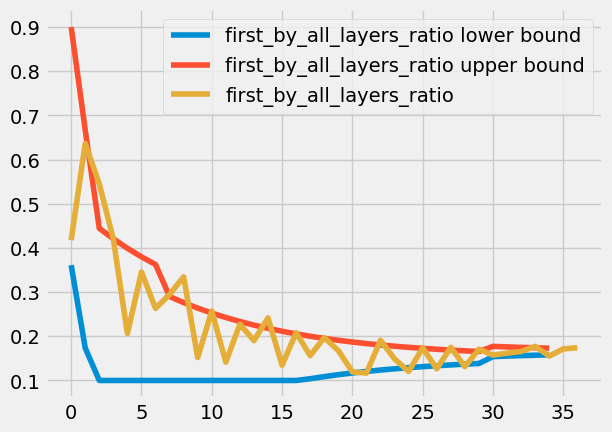

In [88]:
# example first_by_all_layers_ratio-bound shrinking
first_by_all_layers_ratio_min_bound = [b[1][0] for b in bounds_transformer.bounds]
first_by_all_layers_ratio_max_bound = [b[1][1] for b in bounds_transformer.bounds]
first_by_all_layers_ratio = [first_by_all_layers_ratio[1] for first_by_all_layers_ratio in mutating_optimizer_cont.space.params]

plt.plot(first_by_all_layers_ratio_min_bound[1:], label='first_by_all_layers_ratio lower bound')
plt.plot(first_by_all_layers_ratio_max_bound[1:], label='first_by_all_layers_ratio upper bound')
plt.plot(first_by_all_layers_ratio[1:], label='first_by_all_layers_ratio')
plt.legend()

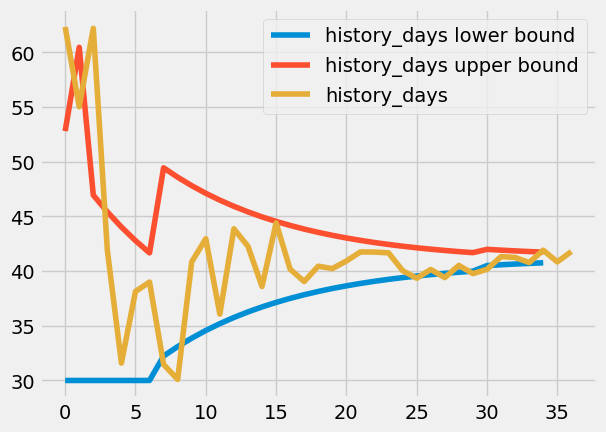

In [89]:
# example history_days-bound shrinking
history_days_min_bound = [b[2][0] for b in bounds_transformer.bounds]
history_days_max_bound = [b[2][1] for b in bounds_transformer.bounds]
history_days = [history_days[2] for history_days in mutating_optimizer_cont.space.params]

plt.plot(history_days_min_bound[1:], label='history_days lower bound')
plt.plot(history_days_max_bound[1:], label='history_days upper bound')
plt.plot(history_days[1:], label='history_days')
plt.legend()

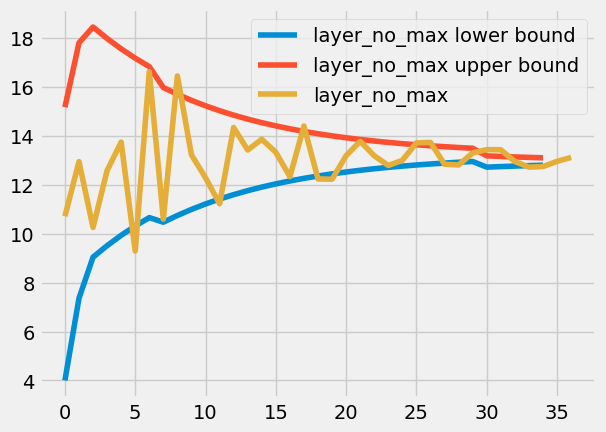

In [90]:
# example layer_no_max-bound shrinking
layer_no_max_min_bound = [b[3][0] for b in bounds_transformer.bounds]
layer_no_max_max_bound = [b[3][1] for b in bounds_transformer.bounds]
layer_no_max = [layer_no_max[3] for layer_no_max in mutating_optimizer_cont.space.params]

plt.plot(layer_no_max_min_bound[1:], label='layer_no_max lower bound')
plt.plot(layer_no_max_max_bound[1:], label='layer_no_max upper bound')
plt.plot(layer_no_max[1:], label='layer_no_max')
plt.legend()

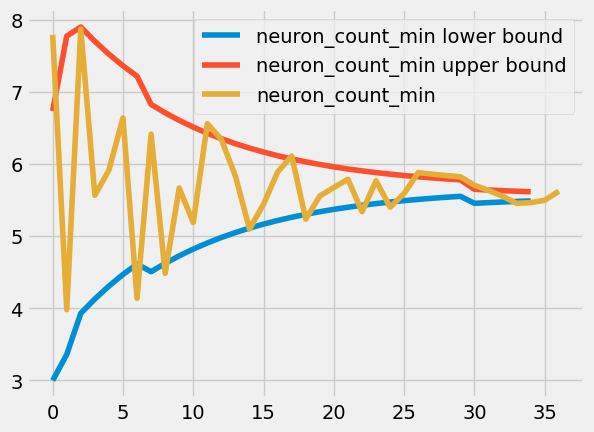

In [91]:
# example neuron_count_min-bound shrinking
neuron_count_min_min_bound = [b[4][0] for b in bounds_transformer.bounds]
neuron_count_min_max_bound = [b[4][1] for b in bounds_transformer.bounds]
neuron_count_min = [neuron_count_min[4] for neuron_count_min in mutating_optimizer_cont.space.params]

plt.plot(neuron_count_min_min_bound[1:], label='neuron_count_min lower bound')
plt.plot(neuron_count_min_max_bound[1:], label='neuron_count_min upper bound')
plt.plot(neuron_count_min[1:], label='neuron_count_min')
plt.legend()

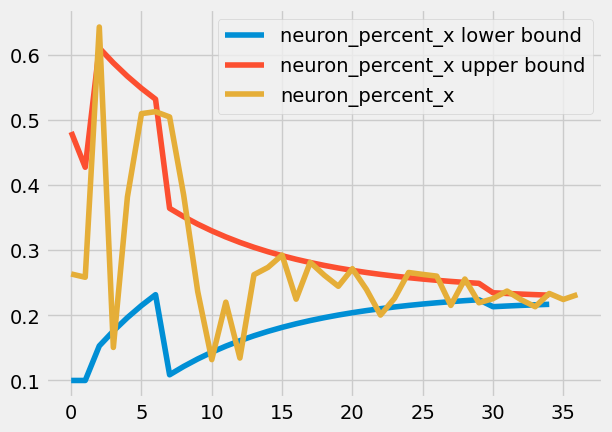

In [92]:
# example neuron_percent_x-bound shrinking
neuron_percent_x_min_bound = [b[5][0] for b in bounds_transformer.bounds]
neuron_percent_x_max_bound = [b[5][1] for b in bounds_transformer.bounds]
neuron_percent_x = [neuron_percent_x[5] for neuron_percent_x in mutating_optimizer_cont.space.params]

plt.plot(neuron_percent_x_min_bound[1:], label='neuron_percent_x lower bound')
plt.plot(neuron_percent_x_max_bound[1:], label='neuron_percent_x upper bound')
plt.plot(neuron_percent_x[1:], label='neuron_percent_x')
plt.legend()

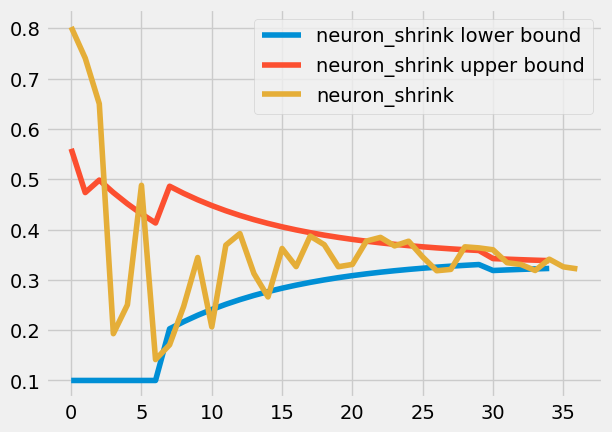

In [93]:
# example neuron_shrink-bound shrinking
neuron_shrink_min_bound = [b[6][0] for b in bounds_transformer.bounds]
neuron_shrink_max_bound = [b[6][1] for b in bounds_transformer.bounds]
neuron_shrink = [neuron_shrink[6] for neuron_shrink in mutating_optimizer_cont.space.params]

plt.plot(neuron_shrink_min_bound[1:], label='neuron_shrink lower bound')
plt.plot(neuron_shrink_max_bound[1:], label='neuron_shrink upper bound')
plt.plot(neuron_shrink[1:], label='neuron_shrink')
plt.legend()

### Get best hyper parameters

In [94]:
mutating_optimizer_cont.max["params"]

{'dropout_rate': 0.499,
 'first_by_all_layers_ratio': 0.16556745288759445,
 'history_days': 41.25063609471126,
 'layer_no_max': 12.943751261400116,
 'neuron_count_min': 5.554960769770928,
 'neuron_percent_x': 0.22397703671826646,
 'neuron_shrink': 0.3304055841383488}

# Fit and evaluate Model with optimized parameters

## Create x & y, define parameters, create and fit model

In [95]:
# Create x and y; x = training and testing data (independent variable),
# y = traget (dependent) variable
x = []
y = []

# x = data of history_days days (interating forward)
# y = last value of history_days days

# get dict of best hyperparameters
best_par = mutating_optimizer_cont.max["params"]

# index_rec_buy_sell_not_nan already was added bay creating the dataset
history_days = int(best_par["history_days"])
for i in range(history_days, scaled_data.shape[0]):
    x.append(scaled_data[i - history_days:i, 0])
    y.append(
        # index_rec_buy_sell_not_nan has to be added because of index of df is used
        [df["Rec(Buy)_bin"][df.index[i + index_rec_buy_sell_not_nan]]]
    )
x = np.array(x)
y = np.array(y)

# create model using best hyperparameters
final_model = create_model(
    x, y,
    first_layer_type="LSTM", second_layer_type="Dense",
    neuron_percent_x=best_par["neuron_percent_x"],
    neuron_shrink=best_par["neuron_shrink"],
    dropout_rate=best_par["dropout_rate"],
    neuron_count_min=int(best_par["neuron_count_min"]),
    layer_no_max=int(best_par["layer_no_max"]),
    first_by_all_layers_ratio=best_par["first_by_all_layers_ratio"],
    activation_function_out="sigmoid", activation_function_dense="relu", 
)
final_model.summary()

# define settings
epochs = 100
batch_size = 128
test_size = 0.2
val_size = 0.3
loss_function = "binary_crossentropy"
optimizer = 'adam'
metrics = ['binary_accuracy']
SPLITS = 10

# get test dataset
boot = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=42)

for train_temp, test in boot.split(x,y):
    # Split train and test
    x_train_temp = x[train_temp]
    x_train_temp = np.reshape(x_train_temp, (x_train_temp.shape[0], x_train_temp.shape[1], 1))
    y_train_temp = y[train_temp]
    x_test = x[test]
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
    y_test = y[test]

# get training and validation dataset
boot = StratifiedShuffleSplit(n_splits=SPLITS, test_size=val_size / (1 - test_size), random_state=43)

for train, val in boot.split(x_train_temp, y_train_temp):
    # Split train and test
    x_train = x[train]
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    y_train = y[train]
    x_val = x[test]
    x_val = np.reshape(x_val, (x_val.shape[0], x_val.shape[1], 1))
    y_val = y[test]
    
    final_model.compile(
        loss=loss_function,
        optimizer=optimizer,
        metrics=metrics
    )
    history = final_model.fit(
        x_train, y_train, validation_data=(x_val, y_val),
        verbose=2,
        epochs=epochs, batch_size=batch_size
    )

resulting_layer_no: 1


Model: "Dense_or_Dense_LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Dense_Layer_1 (Dense)           │ (None, 9)              │           378 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_Layer_1 (Dropout)       │ (None, 9)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_Layer (Dense)            │ (None, 1)              │            10 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 388 (1.52 KB)

 Trainable params: 388 (1.52 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
24/24 - 1s - 26ms/step - binary_accuracy: 0.5554 - loss: 0.6920 - val_binary_accuracy: 0.5632 - val_loss: 0.6911
Epoch 2/100
24/24 - 0s - 3ms/step - binary_accuracy: 0.5659 - loss: 0.6896 - val_binary_accuracy: 0.5632 - val_loss: 0.6917
Epoch 3/100
24/24 - 0s - 3ms/step - binary_accuracy: 0.5649 - loss: 0.6886 - val_binary_accuracy: 0.5632 - val_loss: 0.6933
Epoch 4/100
24/24 - 0s - 3ms/step - binary_accuracy: 0.5649 - loss: 0.6877 - val_binary_accuracy: 0.5632 - val_loss: 0.6936
Epoch 5/100
24/24 - 0s - 3ms/step - binary_accuracy: 0.5649 - loss: 0.6870 - val_binary_accuracy: 0.5632 - val_loss: 0.6927
Epoch 6/100
24/24 - 0s - 3ms/step - binary_accuracy: 0.5649 - loss: 0.6866 - val_binary_accuracy: 0.5632 - val_loss: 0.6905
Epoch 7/100
24/24 - 0s - 3ms/step - binary_accuracy: 0.5649 - loss: 0.6871 - val_binary_accuracy: 0.5632 - val_loss: 0.6878
Epoch 8/100
24/24 - 0s - 3ms/step - binary_accuracy: 0.5649 - loss: 0.6868 - val_binary_accuracy: 0.5632 - val_loss: 0.6865
Epoch 9

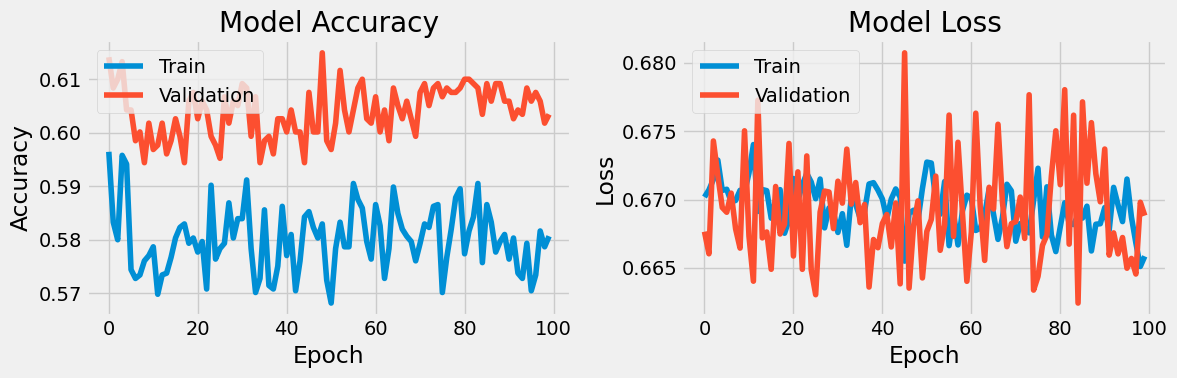

In [104]:
# Plots for Training and Validation Accuracy
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plots for Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [105]:
# Test the model on test data
test_loss, test_acc = final_model.evaluate(x_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)
print('\nTest loss:', test_loss)

39/39 - 0s - 1ms/step - binary_accuracy: 0.6034 - loss: 0.6688

Test accuracy: 0.6034482717514038

Test loss: 0.668821394443512


## Try again with 1st layer as LSTM

In [110]:
# create model using best hyperparameters
x_new_shape = x.reshape((x.shape[0], x.shape[1], 1))

LSTM_model = create_model(
    x_new_shape, y,
    first_layer_type="LSTM", second_layer_type="Dense",
    neuron_percent_x=best_par["neuron_percent_x"],
    neuron_shrink=0.6,
    dropout_rate=best_par["dropout_rate"],
    neuron_count_min=int(best_par["neuron_count_min"]),
    layer_no_max=int(best_par["layer_no_max"]),
    first_by_all_layers_ratio=0.4,
    activation_function_out="sigmoid", activation_function_dense="relu", 
)
LSTM_model.summary()

# get training and validation dataset
boot = StratifiedShuffleSplit(n_splits=SPLITS, test_size=val_size / (1 - test_size), random_state=43)

for train, val in boot.split(x_train_temp, y_train_temp):
    # Split train and test
    x_train = x[train]
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    y_train = y[train]
    x_val = x[test]
    x_val = np.reshape(x_val, (x_val.shape[0], x_val.shape[1], 1))
    y_val = y[test]
    
    LSTM_model.compile(
        loss=loss_function,
        optimizer=optimizer,
        metrics=metrics
    )
    history_LSTM = LSTM_model.fit(
        x_train, y_train, validation_data=(x_val, y_val),
        verbose=2,
        epochs=epochs, batch_size=batch_size
    )

resulting_layer_no: 2


Model: "Dense_or_Dense_LSTM_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ LSTM_Layer_1 (LSTM)             │ (None, 9)              │           396 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_Layer_1 (Dropout)       │ (None, 9)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_Layer_2 (Dense)           │ (None, 5)              │            50 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_Layer_2 (Dropout)       │ (None, 5)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_Layer (Dense)            │ (None, 1)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 452 (1.77 KB)

 Trainable params: 452 (1.77 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
24/24 - 1s - 62ms/step - binary_accuracy: 0.5508 - loss: 0.6917 - val_binary_accuracy: 0.5632 - val_loss: 0.6904
Epoch 2/100
24/24 - 0s - 10ms/step - binary_accuracy: 0.5619 - loss: 0.6887 - val_binary_accuracy: 0.5632 - val_loss: 0.6883
Epoch 3/100
24/24 - 0s - 10ms/step - binary_accuracy: 0.5636 - loss: 0.6885 - val_binary_accuracy: 0.5632 - val_loss: 0.6873
Epoch 4/100
24/24 - 0s - 9ms/step - binary_accuracy: 0.5616 - loss: 0.6866 - val_binary_accuracy: 0.5632 - val_loss: 0.6869
Epoch 5/100
24/24 - 0s - 9ms/step - binary_accuracy: 0.5659 - loss: 0.6856 - val_binary_accuracy: 0.5632 - val_loss: 0.6864
Epoch 6/100
24/24 - 0s - 10ms/step - binary_accuracy: 0.5662 - loss: 0.6847 - val_binary_accuracy: 0.5632 - val_loss: 0.6862
Epoch 7/100
24/24 - 0s - 10ms/step - binary_accuracy: 0.5633 - loss: 0.6892 - val_binary_accuracy: 0.5632 - val_loss: 0.6863
Epoch 8/100
24/24 - 0s - 9ms/step - binary_accuracy: 0.5649 - loss: 0.6863 - val_binary_accuracy: 0.5632 - val_loss: 0.6860
Epo

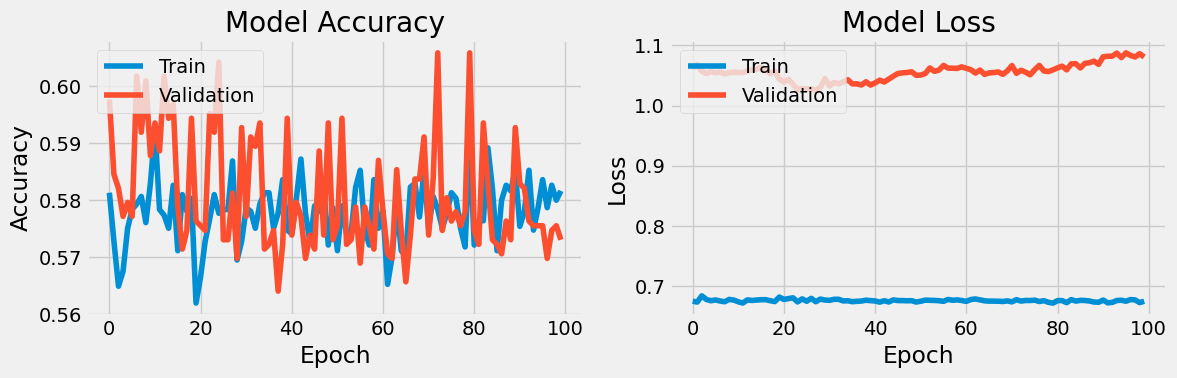

In [112]:
# Plots for Training and Validation Accuracy
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_LSTM.history['binary_accuracy'])
plt.plot(history_LSTM.history['val_binary_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plots for Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(history_LSTM.history['loss'])
plt.plot(history_LSTM.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()